# Time-Series Analysis using Greykites: Dhaka Tribune

## Highlights

* Dataset: Dhaka Tribune 2021 Dataset.

Author: Sumaia Parveen Shupti

Created on: 07/07/2021

Updated on: 07/31/2021

In [21]:
%matplotlib inline
!pip install -qqq greykite

In [22]:
from collections import defaultdict
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
import pandas as pd
import plotly
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster 
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
import sys
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore')
sys.path.append("../")

### Load & Preprocess Dataset

In [24]:
df = pd.read_csv('../input/dhakatribunecomplete/Dhaka Tribune Complete Data.csv')
df['Accident date'] = pd.to_datetime(df['Accident date'])

df = df[['Accident date', 'Deaths']]
df.columns = ['Period', 'Deaths']
df = df.sort_values(by = 'Period')
df = df.dropna()
df = df.set_index('Period').resample('1W').sum()
df = df.reset_index()
df['Period'] = df['Period'].dt.date
#df['Deaths'] = df['Deaths'].fillna(0)
#df = df.set_index('Period')
df

,Period,Deaths
0,2016-06-26,3.0
1,2016-07-03,0.0
2,2016-07-10,0.0
3,2016-07-17,4.0
4,2016-07-24,0.0
...,...,...
257,2021-05-30,3.0
258,2021-06-06,11.0
259,2021-06-13,8.0
260,2021-06-20,16.0


In [25]:
start_ = df.Period.max()
end_ = df.Period.min()

test_end = df.Period.max()
test_start = df.Period.max() - timedelta(days = 60)

train_end = test_start - timedelta(days = 1)
train_start = train_end - timedelta(days = 365*5)

print('Dataset Start Date: {}'.format(start_))
print('Dataset End Date: {}'.format(end_))
print (' ')
print('Train Set Start Date: {}'.format(train_start))
print('Train Set End Date: {}'.format(train_end))
print (' ')
print('Test Set Start Date: {}'.format(test_start))
print('Test Set End Date: {}'.format(test_end))
print (' ')

Dataset Start Date: 2021-06-27
Dataset End Date: 2016-06-26
 
Train Set Start Date: 2016-04-28
Train Set End Date: 2021-04-27
 
Test Set Start Date: 2021-04-28
Test Set End Date: 2021-06-27
 


In [26]:
mask = (df.Period > train_start) & (df.Period <= train_end)
train = df.loc[mask]
#train = train.drop('Period', 1)
#train = train.drop('Date', 1)

mask = (df.Period >= test_start) & (df.Period <= test_end)
test = df.loc[mask]
#test = test.drop('Period', 1)
#test = test.drop('Date', 1)

In [27]:
train

,Period,Deaths
0,2016-06-26,3.0
1,2016-07-03,0.0
2,2016-07-10,0.0
3,2016-07-17,4.0
4,2016-07-24,0.0
...,...,...
248,2021-03-28,26.0
249,2021-04-04,7.0
250,2021-04-11,4.0
251,2021-04-18,25.0


In [28]:
len(test)

9

In [29]:
test

,Period,Deaths
253,2021-05-02,12.0
254,2021-05-09,11.0
255,2021-05-16,20.0
256,2021-05-23,28.0
257,2021-05-30,3.0
258,2021-06-06,11.0
259,2021-06-13,8.0
260,2021-06-20,16.0
261,2021-06-27,5.0


In [30]:
train.columns = ['ts', 'y']
test.columns = ['ts', 'y']

In [31]:
# Specifies dataset information
metadata = MetadataParam(
     time_col="ts",  # name of the time column
     value_col="y",  # name of the value column
     freq="W"  #"MS" for Montly at start date, "H" for hourly, "D" for daily, "W" for weekly, etc.
 )
forecaster = Forecaster()
result = forecaster.run_forecast_config(
     df=train,
     config=ForecastConfig(
         model_template=ModelTemplateEnum.SILVERKITE.name,
         forecast_horizon=9,  # forecasts 100 steps ahead
         coverage=0.95,  # 95% prediction intervals
         metadata_param=metadata
    )
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


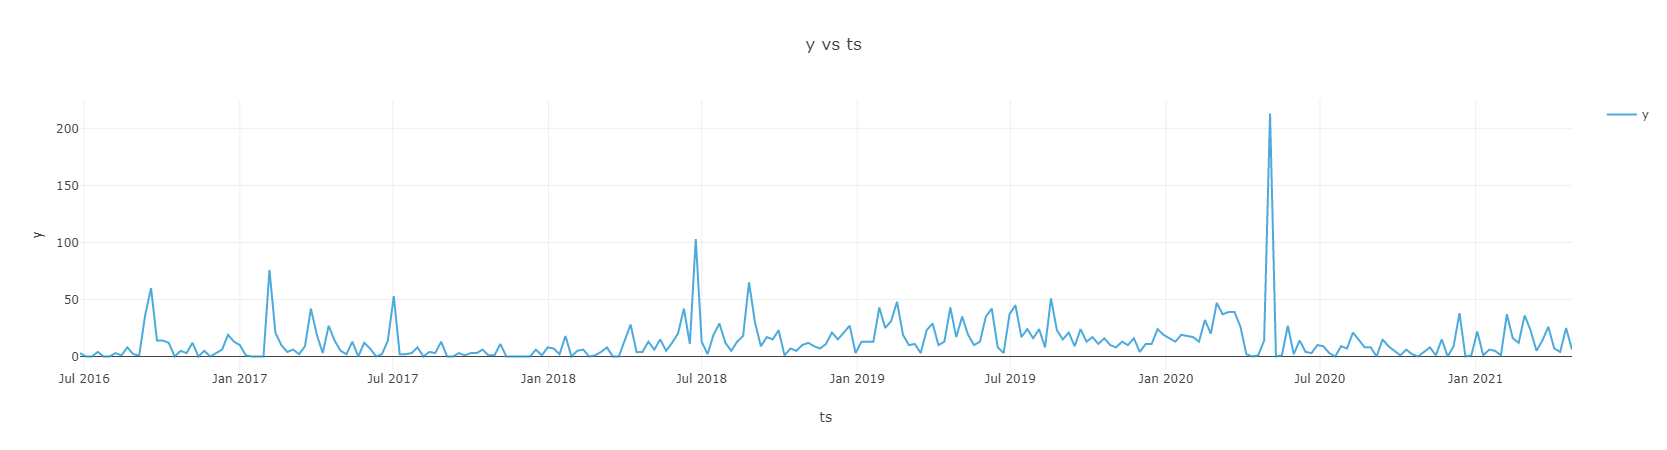

In [32]:
ts = result.timeseries
fig = ts.plot()
plotly.io.show(fig)

In [33]:
grid_search = result.grid_search
cv_results = summarize_grid_search_results(
     grid_search=grid_search,
     decimals=2,
     # The below saves space in the printed output. Remove to show all available metrics and columns.
     cv_report_metrics=None,
     column_order=["rank", "mean_test", "split_test", "mean_train", "split_train", "mean_fit_time", "mean_score_time", "params"])
# Transposes to save space in the printed output
cv_results["params"] = cv_results["params"].astype(str)
cv_results.set_index("params", drop=True, inplace=True)
cv_results.transpose()

params,[]
rank_test_MAPE,1
mean_test_MAPE,NaN
split_test_MAPE,"(nan, nan, 607.2)"
mean_train_MAPE,NaN
split_train_MAPE,"(nan, nan, nan)"
mean_fit_time,9.62
mean_score_time,0.84


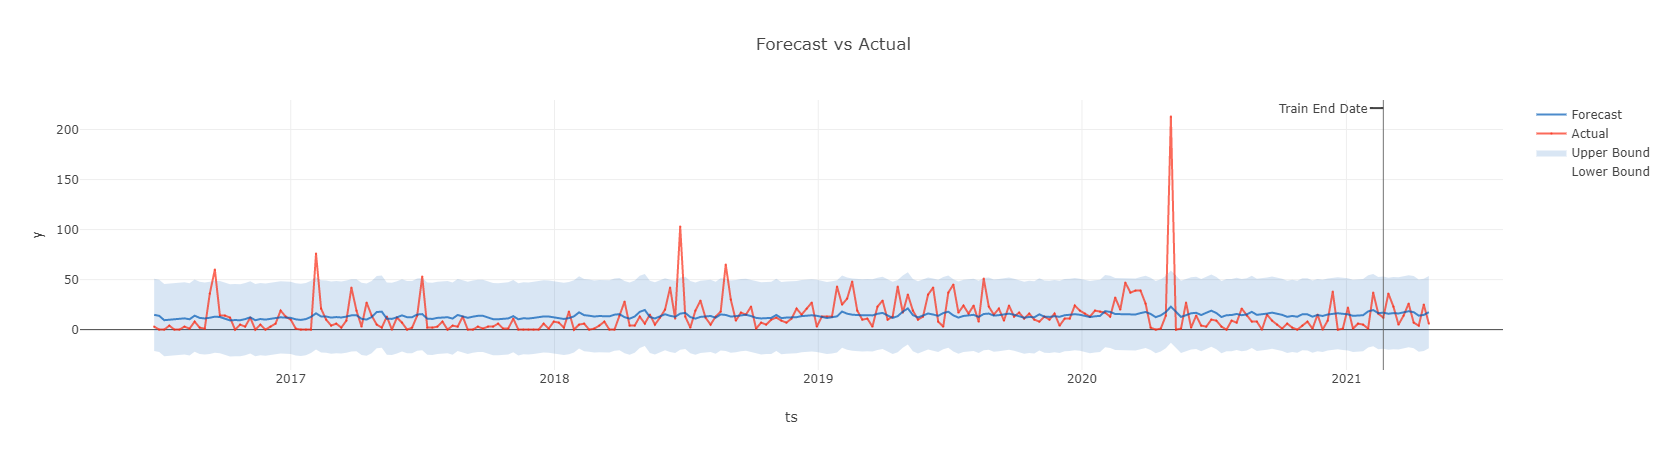

In [34]:
backtest = result.backtest
fig = backtest.plot()
plotly.io.show(fig)

In [35]:
backtest_eval = defaultdict(list)
for metric, value in backtest.train_evaluation.items():
     backtest_eval[metric].append(value)
     backtest_eval[metric].append(backtest.test_evaluation[metric])
metrics = pd.DataFrame(backtest_eval, index=["train", "test"]).T
metrics

,train,test
CORR,0.41483,0.03688
R2,0.084179,-0.00606
MSE,337.626535,120.677505
RMSE,18.374617,10.985331
MAE,10.543272,10.084394
MedAE,8.310849,10.316536
MAPE,NaN,109.96511
MedAPE,NaN,55.917034
sMAPE,42.997405,34.263945
Q80,5.271636,4.988318


In [36]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

In [37]:
forecast.df[len(train):]

,ts,actual,forecast,forecast_lower,forecast_upper
253,2021-05-02,NaN,13.873012,-23.376835,51.122860
254,2021-05-09,NaN,13.853951,-23.395897,51.103798
255,2021-05-16,NaN,13.820148,-23.429699,51.069996
256,2021-05-23,NaN,13.825176,-23.424671,51.075023
257,2021-05-30,NaN,13.839777,-23.410070,51.089625
258,2021-06-06,NaN,13.846410,-23.403437,51.096257
259,2021-06-13,NaN,13.828233,-23.421614,51.078081
260,2021-06-20,NaN,13.839555,-23.410293,51.089402
261,2021-06-27,NaN,13.858314,-23.391534,51.108161


In [38]:
comparison = pd.DataFrame()
comparison['Actual'] = test.y
comparison['Prediction'] = list(forecast.df[len(train):].forecast.values)
comparison['Prediction'] = round(comparison['Prediction'])
comparison

,Actual,Prediction
253,12.0,14.0
254,11.0,14.0
255,20.0,14.0
256,28.0,14.0
257,3.0,14.0
258,11.0,14.0
259,8.0,14.0
260,16.0,14.0
261,5.0,14.0


In [39]:
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

errors = comparison['Actual'] - comparison['Prediction']
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
mape = np.abs(errors/comparison['Actual']).mean() * 100
r2 = r2_score(comparison['Actual'], comparison['Prediction'])

In [40]:
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
print('R2 Score: {:.4f}'.format(r2))

Mean Absolute Error: 6.2222
Mean Squared Error: 55.1111
Root Mean Square Error: 7.4237
Mean Absolute Percentage Error: 87.2643
R2 Score: -0.0333


## Reference

* https://github.com/linkedin/greykite